In [99]:
from langchain.retrievers import WikipediaRetriever
retriever = WikipediaRetriever(load_all_available_meta=True)
# docs = retriever.get_relevant_documents(query="Beijing")

In [98]:
docs[0].page_content

"Beijing, previously romanized as Peking, is the capital of China. With more than 22 million residents, it is the world's most populous national capital city as well as China's second largest city after Shanghai. It is located in Northern China, and is governed as a municipality under the direct administration of the State Council with 16 urban, suburban, and rural districts. Beijing is mostly surrounded by Hebei Province and neighbors Tianjin to the southeast; together, the three divisions form the Jing-Jin-Ji cluster. It is ranked as the 10th most important city in the world by Knight Frank. \nBeijing is a global city and one of the world's leading centres for culture, diplomacy, politics, finance, business and economics, education, research, language, tourism, media, sport, science and technology and transportation and art. It is home to the headquarters of most of China's largest state-owned companies and houses the largest number of Fortune Global 500 companies in the world, as we

In [111]:
import statsmodels.api as sm
import pandas as pd

# 创建数据
data = pd.DataFrame({
    'advertising': [100, 200, 300, 400, 500, 600, 700, 800],
    'sales': [10, 20, 30, 40, 50, 60, 70, 80]
})

# 定义自变量和因变量
X = data['advertising']
y = data['sales']

# 添加常数项
X = sm.add_constant(X)

# 拟合模型
model = sm.OLS(y, X).fit()

# 查看结果
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.260e+31
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           1.95e-93
Time:                        15:46:06   Log-Likelihood:                 246.67
No. Observations:                   8   AIC:                            -489.3
Df Residuals:                       6   BIC:                            -489.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const                0   8.84e-15          0      

/home/hhy/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [120]:
new_data = pd.DataFrame({'advertising': [900, 1000, 1100]})
new_X = sm.add_constant(new_data)
new_predictions = model.predict(new_X)
print(new_predictions)

0     90.0
1    100.0
2    110.0
dtype: float64


In [117]:
model.predict(X)

0    10.0
1    20.0
2    30.0
3    40.0
4    50.0
5    60.0
6    70.0
7    80.0
dtype: float64

In [1]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

In [2]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "/mnt/d/LLM_models/多模态大模型/Qwen2-VL-2B-Instruct", 
    torch_dtype=torch.bfloat16, 
    attn_implementation="flash_attention_2",
    device_map="auto",
)
processor = AutoProcessor.from_pretrained("/mnt/d/LLM_models/多模态大模型/Qwen2-VL-2B-Instruct")

You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# The default range for the number of visual tokens per image in the model is 4-16384. You can set min_pixels and max_pixels according to your needs, such as a token count range of 256-1280, to balance speed and memory usage.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)


In [4]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "/home/hhy/MEABM/figs/bar-event-intervention.png",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

["The image is a set of charts and graphs that represent various economic indicators over time. Here's a detailed description:\n\n### Top Row (Left to Right):\n1. **Price**:\n   - The graph shows a series of lines representing different price indices over time.\n   - The lines are shaded in different colors, indicating different price indices.\n\n2. **Interest Rate**:\n   - Another series of lines representing interest rates over time.\n   - The lines are also shaded differently to distinguish between different interest rate levels.\n\n3. **Inflation Rate**:\n   - A line graph showing the inflation rate over time.\n   - The graph has"]


In [8]:
# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=1024)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

["The image is a set of charts and graphs that represent various economic indicators over time. Here's a detailed description:\n\n### Top Row (Left to Right):\n1. **Price**:\n   - The graph shows a series of lines representing different price indices over time.\n   - The lines are shaded in different colors, indicating different price indices.\n\n2. **Interest Rate**:\n   - Another series of lines representing interest rates over time.\n   - The lines are also shaded differently to distinguish between different interest rate levels.\n\n3. **Inflation Rate**:\n   - A line graph showing the inflation rate over time.\n   - The graph has a red dashed line indicating the inflation target.\n\n4. **Employment Rate**:\n   - A line graph showing the employment rate over time.\n   - The graph has a red dashed line indicating the unemployment rate.\n\n5. **Gini Coefficient**:\n   - A line graph showing the Gini coefficient over time.\n   - The graph has a red dashed line indicating the Lorenz cur

In [9]:
print(output_text[0])

The image is a set of charts and graphs that represent various economic indicators over time. Here's a detailed description:

### Top Row (Left to Right):
1. **Price**:
   - The graph shows a series of lines representing different price indices over time.
   - The lines are shaded in different colors, indicating different price indices.

2. **Interest Rate**:
   - Another series of lines representing interest rates over time.
   - The lines are also shaded differently to distinguish between different interest rate levels.

3. **Inflation Rate**:
   - A line graph showing the inflation rate over time.
   - The graph has a red dashed line indicating the inflation target.

4. **Employment Rate**:
   - A line graph showing the employment rate over time.
   - The graph has a red dashed line indicating the unemployment rate.

5. **Gini Coefficient**:
   - A line graph showing the Gini coefficient over time.
   - The graph has a red dashed line indicating the Lorenz curve.

### Middle Row (Le

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
def fit_sarma_model(data, order, seasonal_order):
    """
    拟合 SARMA 模型

    :param data: 时间序列数据 (Pandas Series)
    :param order: 自回归和移动平均部分的阶数 (p, d, q)
    :param seasonal_order: 季节性部分的阶数 (P, D, Q, S)
    :return: 拟合后的 SARMA 模型
    """
    model = sm.tsa.SARIMAX(data, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    return results

def plot_forecast(results, data, steps=10):
    """
    绘制模型预测结果

    :param results: 拟合后的 SARMA 模型结果
    :param steps: 预测的步数
    """
    forecast = results.get_forecast(steps=steps)
    forecast_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), 
                                    periods=steps, freq='M')
    
    forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
    
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data.values, label='Original Data', color='red')
    plt.plot(data.index, results.fittedvalues, label='Fitted Values', color='blue')
    plt.plot(forecast_series, label='Forecast', color='orange')
    plt.title('SARMA Model Forecast')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


In [7]:
results = fit_sarma_model(data=10 + np.sin(np.linspace(0, 10 * np.pi, 120)) + np.random.normal(size=120),
                          order=(3, 0, 1),
                          seasonal_order=(3, 1, 0, 12),)


In [11]:
forecast = results.get_forecast(10)
forecast.predicted_mean

array([10.97323607, 11.06741298, 10.20714019, 10.89906548, 11.20190654,
        9.9769077 ,  9.75221539, 11.26922556, 10.69789413,  9.15847668])

In [10]:
# 定义迭代范围
max_p = 3  # p（自回归阶数）
max_d = 3  # d（差分阶数）数据以及平稳不需要差分
max_q = 3  # q（移动平均阶数）

max_P = 3  # 季节性自回归阶数
max_D = 3  # 季节性差分阶数
max_Q = 3  # 季节性移动平均阶数
seasonal_period = 12 # 季节周期为12 一年一周期12个月

best_aic = float('inf')  # 初始化最小 AIC 值
best_params = None  # 初始化最优参数组合

# 迭代搜索最优参数组合
for p in range(max_p + 1):
    for d in range(max_d + 1):
        for q in range(max_q + 1):
            for P in range(max_P + 1):
                for D in range(max_D + 1):
                    for Q in range(max_Q + 1):
                        if p + d + q > 0:
                            try:
                                # 使用 SARIMAX 模型拟合数据
                                with warnings.catch_warnings():
                                    warnings.filterwarnings("ignore", category=UserWarning)
                                    model = SARIMAX(data, order=(p, d, q), 
                                                    seasonal_order=(P, D, Q, seasonal_period),
                                                   enforce_stationarity=False,# 是否强制模型保持平稳性
                                                   enforce_invertibility=False )# 可逆性的参数
                                    results = model.fit(disp=False)

                                # 获取拟合的 AIC 值
                                    aic = results.aic

                                # 更新最小 AIC 值和对应的参数组合
                                if aic < best_aic:
                                    best_aic = aic
                                    print(best_aic, (p, d, q, P, D, Q))
                                    best_params = (p, d, q, P, D, Q)

                            except:
                                continue

# 打印最小 AIC 值和对应的参数组合
print("Best Parameters (p, d, q, P, D, Q):", best_params)
print("Best AIC:", best_aic)

756.210483119965 (0, 0, 1, 0, 0, 0)
604.1192999047578 (0, 0, 1, 0, 0, 1)
498.7528977553059 (0, 0, 1, 0, 0, 2)
436.49299131157716 (0, 0, 1, 0, 1, 0)
323.2037300925254 (0, 0, 1, 0, 1, 1)
277.36516038493056 (0, 0, 1, 0, 1, 2)
223.9694202880886 (0, 0, 1, 0, 1, 3)
214.409018062374 (0, 0, 1, 1, 1, 3)
206.44304112696895 (0, 0, 1, 1, 2, 3)
199.7559568037349 (0, 0, 1, 3, 3, 0)
199.30482854692968 (0, 0, 1, 3, 3, 1)
191.1311478693982 (0, 0, 1, 3, 3, 3)
180.55985564409482 (0, 0, 3, 3, 2, 3)


In [9]:
results.aic

360.47310274634384

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  120
Model:             SARIMAX(3, 0, 1)x(3, 1, [], 12)   Log Likelihood                -172.237
Date:                             Sun, 18 Aug 2024   AIC                            360.473
Time:                                     00:43:09   BIC                            381.930
Sample:                                 01-31-1920   HQIC                           369.173
                                      - 12-31-1929                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1305      0.366     -0.357      0.721      -0.848       0.587
ar.L2          0.2254      

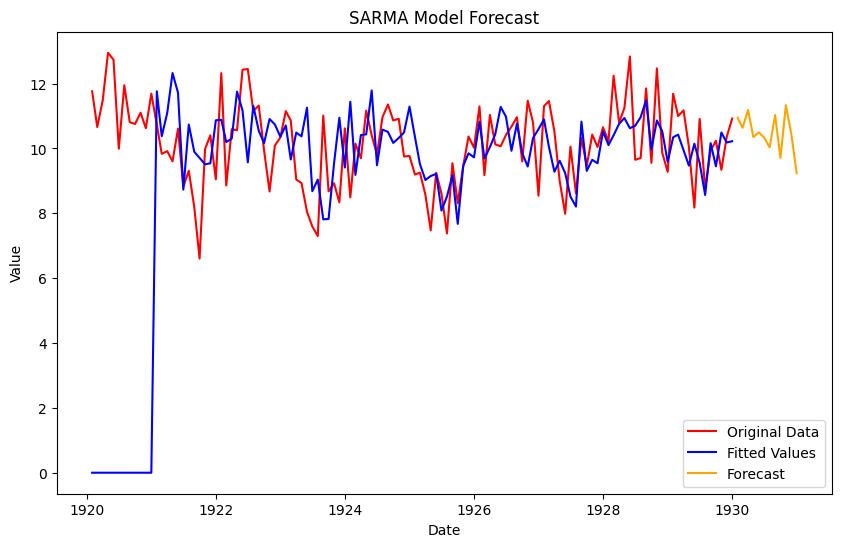

In [8]:
# 示例：使用生成的季节性数据
np.random.seed(0)
# date_range = pd.date_range(start='1920-01-01', periods=120, freq='M')
# data = pd.Series(10 + np.sin(np.linspace(0, 10 * np.pi, 120)) + np.random.normal(size=120), 
#                     index=date_range)

# 拟合 SARMA 模型
order = (3, 0, 1)  # (p, d, q)
seasonal_order = (3, 1, 0, 12)  # (P, D, Q, S)
results = fit_sarma_model(data, order, seasonal_order)

# 打印模型摘要
print(results.summary())

# 绘制预测
plot_forecast(results, data, steps=12)

In [12]:
forecast = results.get_forecast(steps=10)

In [12]:
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

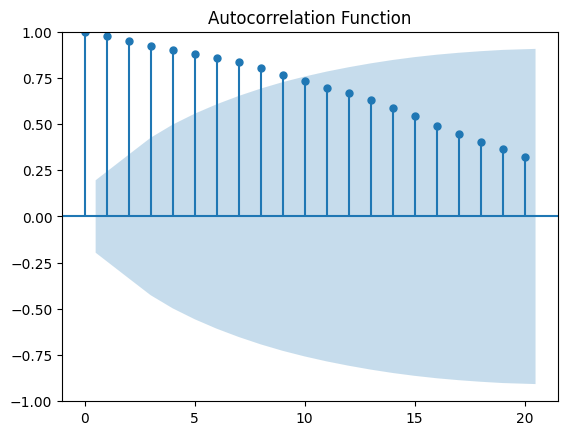

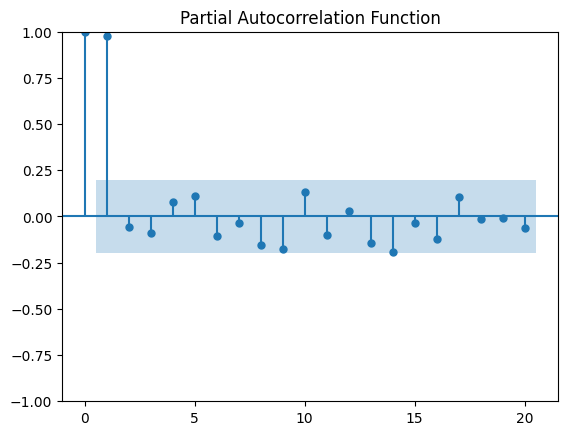

/home/hhy/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/hhy/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(3, 3, 3)   Log Likelihood                -139.381
Date:                Sun, 18 Aug 2024   AIC                            292.762
Time:                        01:31:55   BIC                            310.785
Sample:                             0   HQIC                           300.050
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0164      0.278     -3.652      0.000      -1.562      -0.471
ar.L2          0.0055      0.208      0.027      0.979      -0.402       0.413
ar.L3          0.0359      0.130      0.276      0.7

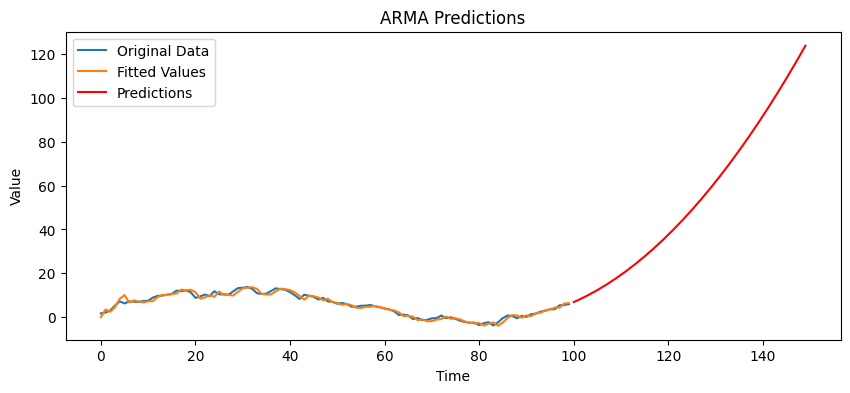

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 生成示例数据
np.random.seed(0)
n = 100
data = np.random.randn(n).cumsum()  # 生成随机游走数据
ts = pd.Series(data)



# ACF 和 PACF 图
plot_acf(ts, lags=20)
plt.title('Autocorrelation Function')
plt.show()

plot_pacf(ts, lags=20)
plt.title('Partial Autocorrelation Function')
plt.show()

# 定义并拟合 ARMA 模型
model = ARIMA(ts, order=(3, 3, 3))  # ARMA(2, 2)
model_fit = model.fit()

print(model_fit.summary())

# 进行预测
predictions = model_fit.forecast(steps=50)
print("Predictions for the next 10 time steps:")
print(predictions)

# 绘制时间序列图
plt.figure(figsize=(10, 4))
plt.plot(ts, label='Original Data')
plt.plot(model_fit.fittedvalues, label='Fitted Values')
plt.plot(range(len(ts), len(ts) + 50), predictions, label='Predictions', color='red')
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARMA Predictions')
plt.legend()
plt.show()

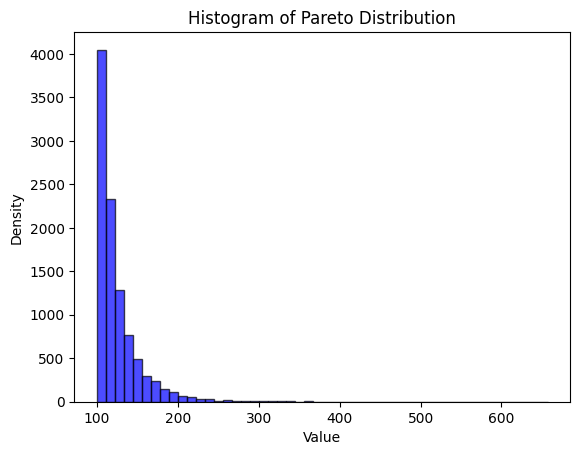

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def pareto(alpha, m, size=1000):
    """Generate random samples from a Pareto distribution."""
    u = np.random.rand(size)
    samples = m / np.power(u, 1.0/alpha)
    return samples

# Parameters for Pareto distribution
alpha = 5  # Shape parameter
m = 100.0  # Scale parameter

# Generate Pareto distributed samples
samples = pareto(alpha, m, size=10000)

# Plotting the histogram
plt.hist(samples, bins=50, density=False, alpha=0.7, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of Pareto Distribution')

# Show plot
plt.show()


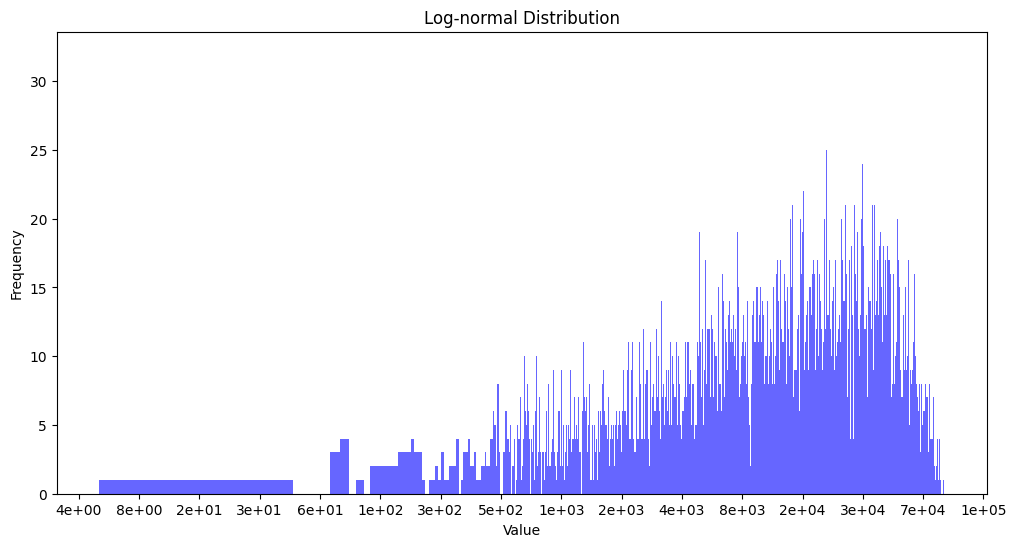

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FormatStrFormatter

# 设置随机种子以确保可重复性
np.random.seed(42)

# 生成对数正态分布的数据
mu = 3     # 对数正态分布的均值（对数刻度）
sigma = 1  # 对数正态分布的标准差（对数刻度）
# s = np.random.lognormal(mu, sigma, 1000)
alpha, beta = 1.5, 2
s = np.random.beta(alpha, beta, 100000) * 168 * 500


# 绘制统计直方图
plt.figure(figsize=(12, 6))
count, bins, ignored = plt.hist(s, bins=10000, density=False, alpha=0.6, color='b')

# # 为了对比，在同一图上绘制对数正态分布的概率密度函数（PDF）
# x = np.linspace(min(s), max(s), 10000)
# pdf = (np.exp(-(np.log(x) - mu) ** 2 / (2 * sigma ** 2))
#        / (x * sigma * np.sqrt(2 * np.pi)))
# plt.plot(x, pdf, linewidth=2, color='r')

# # 设置对数刻度
plt.xscale('log')
ax = plt.gca()
ax.xaxis.set_major_locator(LogLocator(base=2.0, numticks=100))
ax.xaxis.set_minor_locator(LogLocator(base=2.0, subs='auto', numticks=100))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.e'))

# 设置图表标题和标签
plt.title('Log-normal Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [115]:
ss = [sss*12 for sss in s if sss>=500]
count, bins, ignored = plt.hist(ss, bins=5000, density=False, alpha=0.6, color='b')
plt.xscale('log')

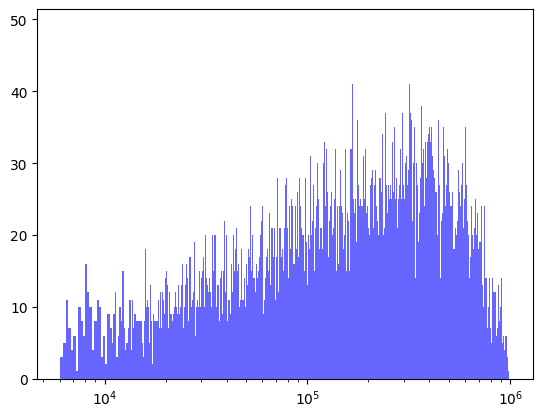

In [116]:
count, bins, ignored = plt.hist(ss, bins=5000, density=False, alpha=0.6, color='b')
plt.xscale('log')

In [1]:
from utils import beta_dist

[1.0848554  1.0766936  1.30679079 1.04433821 1.00552396 1.03578304
 2.21900343 1.13360808 1.06479214 3.3329926 ]


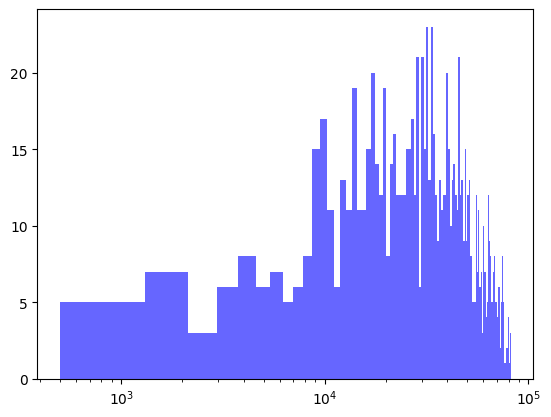

In [11]:
s = []
for i in range(1000):
    s.append(beta_dist()[0])
count, bins, ignored = plt.hist(s, bins=100, density=False, alpha=0.6, color='b')
plt.xscale('log')

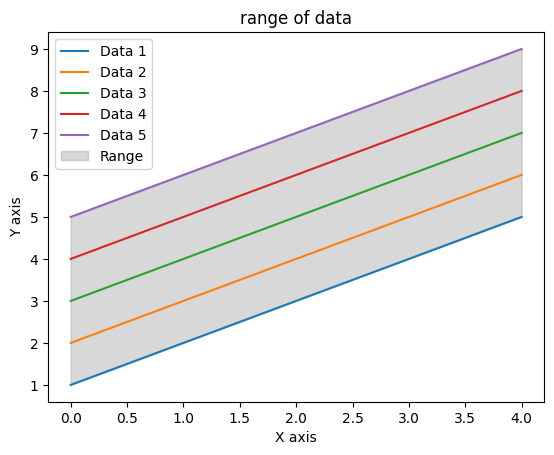

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 假设这是您通过实验得到的五个列表
data1 = [1, 2, 3, 4, 5]
data2 = [2, 3, 4, 5, 6]
data3 = [3, 4, 5, 6, 7]
data4 = [4, 5, 6, 7, 8]
data5 = [5, 6, 7, 8, 9]

# X轴的数据，这里假设是等间隔的整数
x = np.arange(len(data1))

# 计算每个X值对应的所有列表中的最小值和最大值
y_min = [min(data1[i], data2[i], data3[i], data4[i], data5[i]) for i in range(len(data1))]
y_max = [max(data1[i], data2[i], data3[i], data4[i], data5[i]) for i in range(len(data1))]

# 创建一个新的图形
plt.figure()

# 绘制每个列表的线图
plt.plot(x, data1, label='Data 1')
plt.plot(x, data2, label='Data 2')
plt.plot(x, data3, label='Data 3')
plt.plot(x, data4, label='Data 4')
plt.plot(x, data5, label='Data 5')

# 填充波动范围的阴影
plt.fill_between(x, y_min, y_max, color='gray', alpha=0.3, label='Range')

# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title('range of data')
plt.xlabel('X axis')
plt.ylabel('Y axis')

# 显示图形
plt.show()


In [ ]:
from openai import OpenAI

client = OpenAI(api_key='sk-proj-pkqVRU3aNsKQey6RZk0cT3BlbkFJF7O3g5nvhs0iv3akmYok')

response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text", "text": "What’s in this image?"},
        {
          "type": "image_url",
          "image_url": {
            "url": "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg",
          },
        },
      ],
    }
  ],
  max_tokens=300,
)

print(response.choices[0])

In [3]:
import base64
import requests

# OpenAI API Key
api_key = None

# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = "bar-intervention.png"

# Getting the base64 string
base64_image = encode_image(image_path)

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

payload = {
    "model": "gpt-4o-mini",
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "What can you learn from this image?"
                    },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                ]
            }
        ],
    "max_tokens": 300
    }

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)



{'id': 'chatcmpl-9rSh7bHrRB1u1B1KeWCZ7TWrvn0Xm', 'object': 'chat.completion', 'created': 1722528713, 'model': 'gpt-4o-mini-2024-07-18', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'The image appears to be a series of time series plots showcasing various economic indicators over a specified timeframe (measured in months). Here are some insights that can be drawn from the image:\n\n1. **Indicators Overview**: The metrics displayed likely include Price, Interest Rate, Employment Rate, Inflation Rate, Production, Nominal GDP, Deposit per Capita, and a measure of Imbalance between Demand and Supply.\n\n2. **Trends and Fluctuations**: \n   - Most indicators show noticeable fluctuations over time, likely indicating economic cycles or responses to events.\n   - There are marked periods of decay and recovery which might correlate with economic disturbances or policy changes.\n\n3. **Highlighted Periods**: The vertical red dashed lines could represent significant events 

In [7]:
print(response.json()['choices'][0]['message']['content'])

The image appears to be a series of time series plots showcasing various economic indicators over a specified timeframe (measured in months). Here are some insights that can be drawn from the image:

1. **Indicators Overview**: The metrics displayed likely include Price, Interest Rate, Employment Rate, Inflation Rate, Production, Nominal GDP, Deposit per Capita, and a measure of Imbalance between Demand and Supply.

2. **Trends and Fluctuations**: 
   - Most indicators show noticeable fluctuations over time, likely indicating economic cycles or responses to events.
   - There are marked periods of decay and recovery which might correlate with economic disturbances or policy changes.

3. **Highlighted Periods**: The vertical red dashed lines could represent significant events or turning points, such as economic crises, regulatory changes, or other impactful occurrences.

4. **Comparative Analysis**: By examining the relationships between different indicators (e.g., how employment rates 

In [3]:
import cv2, base64
image = cv2.imread('bar-event-intervention.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# cv2.imwrite('/home/bar-intervention_1.png', image[0:1650, 0:1850, :])

success, encoded_image = cv2.imencode('.png', image[130:1650, 130:1850, :])
binary_image = encoded_image.tobytes()
base64_image = base64.b64encode(binary_image).decode('utf-8')


In [4]:
import base64
import requests

# OpenAI API Key
api_key = None
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}
payload = {
    "model": "gpt-4o-mini",
    "messages": [
        {
            "role": "system",
            "content": "You are a high-level economist and good at analyzing and giving professional advices."
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Analyze this price fluctuation figure, and give your five suggestions to central bank to make the price stable. \
                        Note that the red "
                    },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                ]
            }
        ],
    "max_tokens": 500
    }

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
print(response.json()['choices'][0]['message']['content'])

从提供的图表中，可以得出几个见解：

1. **价格随时间的变化趋势**：该图表显示了指定时间段（以月为单位）内价格变化的总体趋势。观察波峰和波谷有助于确定波动期。

2. **重要峰值**：价格出现明显的峰值，表明某些事件或市场条件可能导致价格快速上涨，然后进行修正。

3. **置信区间**：趋势线周围的阴影区域代表价格估计的不确定性或可变性。阴影越宽，表明在这些时期的不确定性更大。

4. **事件时间**：垂直虚线可能表示与价格重大变化相关的关键点或事件，这可能对分析很重要。

5. **价格稳定**：在图表的末尾，价格似乎有一定程度的稳定，表明潜在的市场均衡或波动性降低。

6. **比较分析**：不同颜色的线表示不同价格度量或情景之间的比较，这可能表明不同的市场影响。

7. **进一步调查**：确定主要波动背后的原因可以为未来的预测、风险评估和经济影响提供背景。

总体而言，该图表可以成为理解市场行为和指导投资或政策决策的宝贵工具。


这幅图似乎代表了价格随时间变化的时间串行分析，可能描绘了模拟或预测区间以及实际或预期的价格趋势。以下是基于视觉内容的分析：

1. **时间串行分析**：X 轴表示以月为单位的时间，而 Y 轴表示价格水平。这表明数据集跨越了大约 1200 个月（或 100 年）。

2. **价格趋势（线）**：
有两条不同颜色的线（蓝色和橙色），似乎代表了两种不同的价格趋势分析或模型。
两条线都显示出随时间而来的显着波动，表明波动性较大。

3. **预测区间（阴影区域）**：
线周围的阴影区域表示某种形式的置信度或预测区间，表明不确定性或可变性的范围。
蓝色阴影区域跟踪蓝线，表示该特定模型或数据集的预测存在不确定性。
灰色阴影区域似乎覆盖了后一时期的大部分时间，表明橙色趋势线周围存在不确定性。

4. **重大事件**：有两条垂直虚线（蓝色）似乎标记了特定的时间点（约 600 个月和约 900 个月）。这可能表明影响价格趋势的重大事件或制度变化。

5. **价格飙升**：
大约 600 个月时，价格出现大幅飙升，达到 600 个单位以上，随后是另一个高波动期。
800 个月后，价格再次上涨，虽然没有第一次飙升那幺明显，但价格稳定下来，但仍不稳定。

基于此，分析可以指出几个关键见解：

**波动期**：500-700 个月左右的区域波动性高，价格大幅飙升，表明发生了重大市场事件或结构性变化。
**模型预测**：蓝色和橙色趋势之间的差异可能暗示不同的预测模型或情景。
**置信区间的使用**：决策者应考虑阴影预测区间，以解释模型预测中的不确定性。

进一步的细粒度分析需要了解具体背景，例如，该价格趋势与哪个市场或资产相关，以及哪些外部因素（经济、监管、地缘政治）可能影响了这些确定的变化时期。


In [29]:
print(response.json()['choices'][0]['message']['content'])

This image appears to represent a time series analysis for price variations over time, likely depicting simulation or prediction intervals along with actual or expected price trends. Here is an analysis based on the visual content:

1. **Time Series Analysis**: The X-axis represents time in months, while the Y-axis represents the price level. This indicates that the dataset spans around 1200 months (or 100 years).

2. **Price Trend (Lines)**: 
   - There are two lines in different colors (blue and orange), which seem to represent two different analyses or models of price trends over time.
   - Both lines show significant fluctuations over time, indicating periods of high volatility.

3. **Predictive Intervals (Shaded Areas)**:
   - The shaded areas around the lines represent some form of confidence or predictive intervals, suggesting the range of uncertainty or variability.
   - The blue shaded area tracks the blue line, indicating uncertainty in the prediction for that particular mode

(-0.5, 1719.5, 1519.5, -0.5)

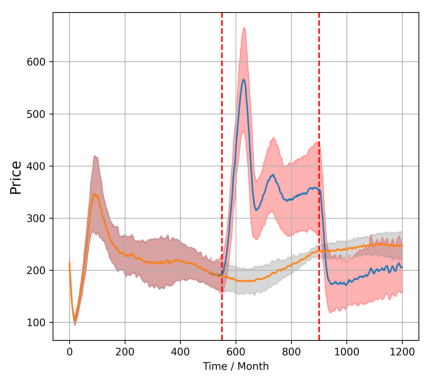

In [24]:
import matplotlib.pyplot as plt
plt.imshow(image[130:1650, 130:1850, :])
plt.axis('off') 

In [14]:
51**0.2-50**0.2

0.00867774954093381

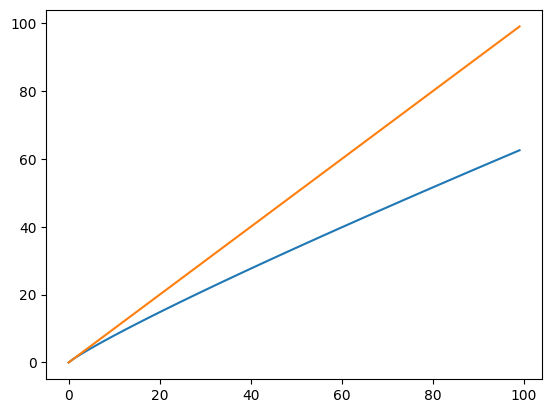

In [20]:
plt.plot(list(range(100)), [i**0.9 for i in range(100)])
plt.plot(list(range(100)), list(range(100)))